# 串起来：让机器人可以简单地玩游戏


In [1]:
from CyClient import *
import time
import numpy as np
from matchUtil import *
from Cut import *
import matplotlib.pyplot as plt
cli = Client()
cli.sayHello()

received:     Hello From Server 


In [101]:
cli.takAction(4,0,0)
time.sleep(0.5)
cli.takAction(3,0,0)

received:     M         4         0         0
received:     M         3         0         0


In [10]:
cli.takAction(1,10,10)

received:     M         1         1 0         1 0


In [78]:
cli.takAction(0,0,5)

received:     M         0         0         5


In [83]:
cli.getPos() # left upper corner  it is 85, 10, 0, right bottom corner is 15 -135 

received: 
(15.0, -135.0, 0)


(15.0, -135.0, 0)

In [2]:
PHONESIZE = (70,145)


In [65]:
class Player:
    def __init__(self,cli):
        self.cli = cli
        self.basePoint = np.array([0,0])
        self.sourceimg = None # the image of the jagsaw to recover
        self.emptyimg = None # the image of the empty target area 
    def setBase(self):
        # move to where 0,0 point should be in the figure
        curr = self.cli.getPos()
        print("current position: ", curr[:2])
        self.basePoint = np.array(curr[:2])
    def moveto(self,x,y):
        x += self.basePoint[0]
        y += self.basePoint[1]
        x,y = int(x),int(y)
        cli.takAction(1,x,y)
        
    def movetoImg(self,x,y,imgshape,diviceShape = PHONESIZE):
        # imgshape is (y_shape, x_shape)
        x =  (1-x/imgshape[1]) * diviceShape[0] # because x is converted
        y =  y/imgshape[0] * diviceShape[1]
        self.moveto(x,y)
    
    def retreat(self):
        self.moveto(-10,-10)
#         self.cli.takAction(3,0,0)
    
    def clickAtImg(self, x, y,imgshape,diviceShape = PHONESIZE):
        print(imgshape,diviceShape)
        self.movetoImg(x, y,imgshape,diviceShape)
        time.sleep(0.5)
#         self.cli.takAction(2,0,0)
        self.cli.takAction(4,0,0)
        time.sleep(0.5)
        self.cli.takAction(3,0,0)
        self.retreat()
    
    def dragAtImg(self, x0,y0,x1,y1,imgshape,diviceShape = PHONESIZE):
        self.movetoImg(x0,y0,imgshape,diviceShape)
        self.cli.takAction(4,0,0)
        self.movetoImg(x1,y1,imgshape,diviceShape)
        self.cli.takAction(3,0,0)
    
    def tryOneDrag(self,x0,y0,x1,y1,imgshape,diviceShape = PHONESIZE):
        # drag the piece to the position and then drag it back
        # if it is the correct piece it will stay there
        self.dragAtImg(x0,y0,x1,y1,imgshape,diviceShape = PHONESIZE)
        time.sleep(2)
        self.dragAtImg(x1,y1+30,x0,y0-30,imgshape,diviceShape = PHONESIZE)
        self.retreat()
        
    def getOneShot(self):
        img = self.cli.getPic()
        img = get_Contour(img)
        return img
    
    def initGame(self):
        # The phone should be before the game start
        self.retreat()
        img = self.getOneShot()
        self.sourceimg = img
        y,x = img.shape[:2]
        x,y = x*0.502,y*0.237
        self.clickAtImg(x,y,img.shape[:2])
        time.sleep(2)
        img = self.getOneShot()
        self.emptyimg = cutout_target(img)
        plt.imshow(self.sourceimg)
        plt.show()
        plt.imshow(self.emptyimg)
        plt.show()
               
        
        
ply = Player(cli)

In [66]:
cli.takAction(1,10,10)

received:     M         1         1 0         1 0


In [67]:

ply.setBase()

received: 
(10.0, 10.0, 0)
current position:  (10.0, 10.0)


In [68]:
ply.retreat()

received:     M         1         0         0


received:     M         1         0         0
received: 
600 800 3
30000
26.565048217773438
(290, 562) (70, 145)
received:     M         1         4 4         4 4
received:     M         4         0         0
received:     M         3         0         0
received:     M         1         0         0
received: 
600 800 3
30000
26.565048217773438


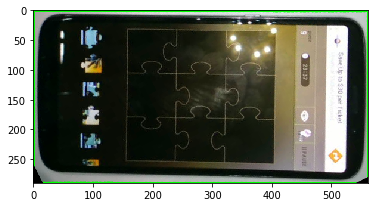

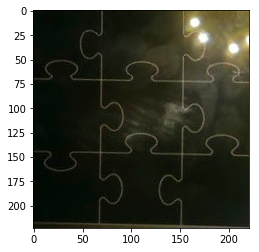

In [69]:
ply.initGame()

In [44]:
ply.tryOneDrag(100,40, 300,100,ply.sourceimg.shape[:2])

NameError: name 'x0210' is not defined

In [129]:
ply.movetoImg(50,0, [50,100] , [70,145] )

received:     M         1         4 5         1 0


received: 
600 800 3
30000
27.100505828857422


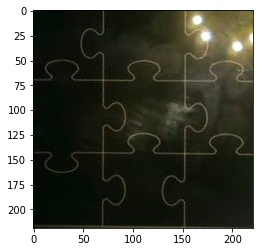

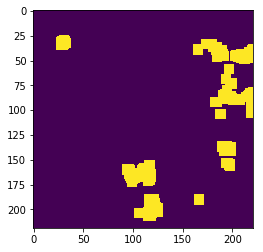

[[10.1444924   0.         51.48808407]
 [ 0.          0.         52.25370614]
 [ 0.         63.45092888 14.21185964]]
possible: [[ True  True  True]
 [ True  True  True]
 [ True  True  True]]
scores: [[ 281694.56337316  595293.86933565  617068.21110213]
 [ 598595.5034936  1145266.21102076  404029.950514  ]
 [2243923.48153321 1204820.19272693 1365758.63582601]]
0 2
received:     M         1         6 5         5 4
received:     M         4         0         0
received:     M         1         4 7         9 1
received:     M         3         0         0
received:     M         1         4 7         1 0 6
received:     M         4         0         0
received:     M         1         6 5         3 9
received:     M         3         0         0
received:     M         1         0         0
received: 
600 800 3
30000
27.91469955444336


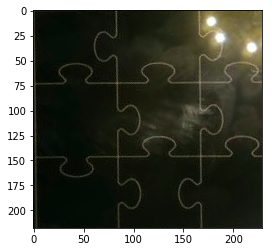

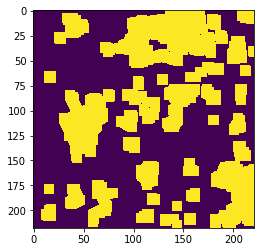

[[ 42.98515982 144.96575342 157.67694064]
 [109.6946347  114.06107306  81.60388128]
 [ 71.65810502  71.12442922 137.83390411]]


In [70]:
def playOneStep(ply):
    img = ply.getOneShot()
    target = cutout_target(img)
    (x0,y0), scores = matching(ply.sourceimg,img.copy(),mode = "match")
    
    sor = cutout_source(ply.sourceimg,img)
    
    plt.imshow(target)
    plt.show()
    possible = findEmpty(ply.emptyimg,target,mode = "debug")
    initial_num = possible.sum()
    print("possible:", possible)
    print("scores:",scores)
    while(possible.sum()>0):
        y = np.argmax(scores)//3 # x => i 
        x = np.argmax(scores)%3
        print(x,y)
        scores[y][x]=-1
        if(not possible[x][y]):
            continue
        possible[x][y] = False
        # add the source area margine
        x = int(x*sor.shape[1]/3)
        y = int(y*sor.shape[0]/3)
        x += int(ply.sourceimg.shape[1]*0.470)
        y += int(ply.sourceimg.shape[0]*0.343)
        ply.tryOneDrag(x0,y0,x,y,img.shape[:2])
        time.sleep(2)
        timg = ply.getOneShot()
        timg = cutout_target(timg)
        
        plt.imshow(timg)
        plt.show()
        empty = findEmpty(ply.emptyimg,timg,mode = "debug")
        
        if(empty.sum()<initial_num):
            break
playOneStep(ply)

2